# Case Técnico iFood Caio Santos — Análise
Este notebook consome exclusivamente a base `orders_enriched.parquet` gerada no pipeline e responde às questões do case




In [29]:
from google.colab import drive
import os

drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/case_ifood"
os.makedirs(BASE_DIR, exist_ok=True)
os.chdir(BASE_DIR)

print("cwd:", os.getcwd())
print("existe data?", os.path.exists("data"))
print("existe reports?", os.path.exists("reports"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cwd: /content/drive/MyDrive/case_ifood
existe data? True
existe reports? True


In [30]:
import os

DIRS = {
    "analytics_orders_enriched": "data/processed/analytics/orders_enriched",
    "analytics_user_metrics": "data/processed/analytics/user_metrics",
    "analytics_user_segments": "data/processed/analytics/user_segments",
    "reports": "reports",
}

for p in DIRS.values():
    os.makedirs(p, exist_ok=True)

PATH_ORDERS_ENRICHED = os.path.join(DIRS["analytics_orders_enriched"], "orders_enriched.parquet")
PATH_USER_METRICS = os.path.join(DIRS["analytics_user_metrics"], "user_metrics.parquet")
PATH_USER_SEGMENTS = os.path.join(DIRS["analytics_user_segments"], "user_segments.parquet")

REPORT_AB_TEST = os.path.join(DIRS["reports"], "ab_test_results.csv")
REPORT_VIAB = os.path.join(DIRS["reports"], "viabilidade_sensibilidade.csv")
REPORT_AB_SEG = os.path.join(DIRS["reports"], "ab_test_por_segmento.csv")
REPORT_RECO = os.path.join(DIRS["reports"], "recomendacoes_resumo.csv")

print("orders_enriched existe?", os.path.exists(PATH_ORDERS_ENRICHED))


orders_enriched existe? True


## 1. Base de métricas por usuário (user_metrics)

Métricas agregadas no nível de usuário (`customer_id`) para avaliar impacto do A/B e suportar segmentação.


In [31]:
import pandas as pd

df = pd.read_parquet(
    PATH_ORDERS_ENRICHED,
    columns=["customer_id", "is_target", "order_id", "order_created_at", "order_total_amount"]
)

df["order_created_at"] = pd.to_datetime(df["order_created_at"], errors="coerce")
df["order_total_amount"] = pd.to_numeric(df["order_total_amount"], errors="coerce")

user_metrics = (
    df.groupby(["customer_id", "is_target"], as_index=False)
      .agg(
          num_orders=("order_id", "nunique"),
          gmv_total=("order_total_amount", "sum"),
          ticket_medio=("order_total_amount", "mean"),
          dias_ativos=("order_created_at", lambda s: s.dt.date.nunique()),
          primeiro_pedido=("order_created_at", "min"),
          ultimo_pedido=("order_created_at", "max"),
      )
)

user_metrics["gmv_total"] = user_metrics["gmv_total"].fillna(0)
user_metrics["ticket_medio"] = user_metrics["ticket_medio"].fillna(0)

user_metrics.to_parquet(PATH_USER_METRICS, index=False)

user_metrics.shape


(806466, 8)

## Levantamentos — Indicadores e impacto do teste A/B

KPIs avaliados no nível de usuário:
- Primário: pedidos por usuário (`num_orders`)
- Secundários: GMV por usuário (`gmv_total`) e % com recompra no período (2+ pedidos)
- Guardrail: ticket médio (`ticket_medio`)

Significância via Welch t-test (médias) e z-test de proporções.


In [32]:
resumo = (
    user_metrics.groupby("is_target", as_index=False)
      .agg(
          users=("customer_id", "nunique"),
          media_pedidos=("num_orders", "mean"),
          mediana_pedidos=("num_orders", "median"),
          media_gmv=("gmv_total", "mean"),
          mediana_gmv=("gmv_total", "median"),
          media_ticket=("ticket_medio", "mean"),
          pct_com_2mais_pedidos=("num_orders", lambda s: float((s >= 2).mean())),
      )
)

resumo


,is_target,users,media_pedidos,mediana_pedidos,media_gmv,mediana_gmv,media_ticket,pct_com_2mais_pedidos
0,control,360542,2.803385,1.0,134.331655,66.7,48.002943,0.476252
1,target,445924,3.176947,2.0,151.886838,80.2,47.834905,0.576163


In [33]:
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

target = user_metrics[user_metrics["is_target"] == "target"].copy()
control = user_metrics[user_metrics["is_target"] == "control"].copy()

def welch_row(metrica):
    t = target[metrica].astype(float)
    c = control[metrica].astype(float)

    mt = float(t.mean())
    mc = float(c.mean())
    diff = mt - mc
    uplift = diff / mc if mc != 0 else np.nan
    p_value = float(stats.ttest_ind(t, c, equal_var=False, nan_policy="omit").pvalue)

    return {
        "metrica": metrica,
        "media_target": mt,
        "media_control": mc,
        "diff_abs": diff,
        "uplift_pct": uplift,
        "p_value": p_value,
        "teste": "welch_t",
    }

rows = [welch_row(m) for m in ["num_orders", "gmv_total", "ticket_medio"]]

t_succ = int((target["num_orders"] >= 2).sum())
c_succ = int((control["num_orders"] >= 2).sum())
t_n = int(len(target))
c_n = int(len(control))

p_prop = float(proportions_ztest([t_succ, c_succ], [t_n, c_n])[1])

rows.append({
    "metrica": "pct_com_2mais_pedidos",
    "media_target": t_succ / t_n,
    "media_control": c_succ / c_n,
    "diff_abs": (t_succ / t_n) - (c_succ / c_n),
    "uplift_pct": (t_succ / t_n) / (c_succ / c_n) - 1,
    "p_value": p_prop,
    "teste": "z_proporcao",
})

df_resultados = pd.DataFrame(rows).sort_values("metrica").reset_index(drop=True)
df_resultados.to_csv(REPORT_AB_TEST, index=False)

df_resultados


,metrica,media_target,media_control,diff_abs,uplift_pct,p_value,teste
0,gmv_total,151.886838,134.331655,17.555183,0.130685,2.343230e-171,welch_t
1,num_orders,3.176947,2.803385,0.373562,0.133254,0.000000e+00,welch_t
2,pct_com_2mais_pedidos,0.576163,0.476252,0.099911,0.209785,0.000000e+00,z_proporcao
3,ticket_medio,47.834905,48.002943,-0.168038,-0.003501,4.447794e-01,welch_t


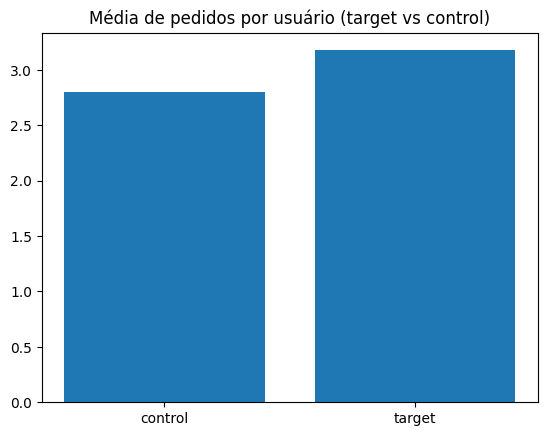

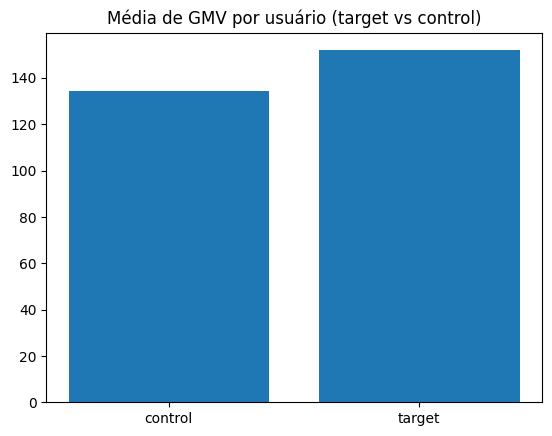

In [34]:
import matplotlib.pyplot as plt

medias = user_metrics.groupby("is_target", as_index=False).agg(
    media_pedidos=("num_orders", "mean"),
    media_gmv=("gmv_total", "mean"),
    media_ticket=("ticket_medio", "mean"),
)

plt.figure()
plt.bar(medias["is_target"], medias["media_pedidos"])
plt.title("Média de pedidos por usuário (target vs control)")
plt.show()

plt.figure()
plt.bar(medias["is_target"], medias["media_gmv"])
plt.title("Média de GMV por usuário (target vs control)")
plt.show()


## 2.1 Heterogeneidade do efeito por cidade (Top 5)

Para investigar se o efeito do cupom varia conforme contexto local, comparei Target vs Control dentro das Top 5 cidades por volume.
As métricas são calculadas por usuário usando apenas pedidos entregues naquela cidade, para manter uma comparação justa.


In [35]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_orders_city = pd.read_parquet(
    PATH_ORDERS_ENRICHED,
    columns=["customer_id", "is_target", "order_id", "order_total_amount", "delivery_address_city"]
).copy()

df_orders_city["delivery_address_city"] = df_orders_city["delivery_address_city"].astype(str).str.strip()
df_orders_city["order_total_amount"] = pd.to_numeric(df_orders_city["order_total_amount"], errors="coerce")

top5_cidades = (
    df_orders_city.groupby("delivery_address_city", as_index=False)
                 .agg(pedidos=("order_id", "nunique"))
                 .sort_values("pedidos", ascending=False)
                 .head(5)["delivery_address_city"]
                 .tolist()
)

df_top5 = df_orders_city[df_orders_city["delivery_address_city"].isin(top5_cidades)].copy()

user_city_metrics = (
    df_top5.groupby(["delivery_address_city", "customer_id", "is_target"], as_index=False)
          .agg(
              num_orders_city=("order_id", "nunique"),
              gmv_city=("order_total_amount", "sum"),
          )
)

city_ab = (
    user_city_metrics.groupby(["delivery_address_city", "is_target"], as_index=False)
      .agg(
          users=("customer_id", "nunique"),
          media_pedidos=("num_orders_city", "mean"),
          media_gmv=("gmv_city", "mean"),
          pct_2mais=("num_orders_city", lambda s: float((s >= 2).mean())),
      )
)

city_pivot = city_ab.pivot(index="delivery_address_city", columns="is_target")
city_pivot.columns = [f"{a}_{b}" for a, b in city_pivot.columns]
city_pivot = city_pivot.reset_index()

city_pivot["uplift_pedidos_pct"] = city_pivot["media_pedidos_target"] / city_pivot["media_pedidos_control"] - 1
city_pivot["uplift_gmv_pct"] = city_pivot["media_gmv_target"] / city_pivot["media_gmv_control"] - 1
city_pivot["diff_pct_2mais"] = city_pivot["pct_2mais_target"] - city_pivot["pct_2mais_control"]

city_pivot = city_pivot.sort_values("uplift_gmv_pct", ascending=False).reset_index(drop=True)
city_pivot


,delivery_address_city,users_control,users_target,media_pedidos_control,media_pedidos_target,media_gmv_control,media_gmv_target,pct_2mais_control,pct_2mais_target,uplift_pedidos_pct,uplift_gmv_pct,diff_pct_2mais
0,BRASILIA,13120,16292,2.690015,3.071999,119.847591,137.425061,0.459604,0.550331,0.142000,0.146665,0.090728
1,RIO DE JANEIRO,58766,73805,3.074788,3.487623,162.529823,185.095907,0.500102,0.599092,0.134264,0.138843,0.098990
2,SAO PAULO,98849,122492,2.751227,3.104260,155.375676,175.698835,0.472711,0.568804,0.128318,0.130800,0.096094
3,FORTALEZA,13253,16942,3.562665,3.955849,140.584963,156.317680,0.542896,0.631685,0.110362,0.111909,0.088789
4,RECIFE,12504,15816,2.846289,3.101100,128.739724,139.752327,0.480566,0.567210,0.089524,0.085542,0.086644


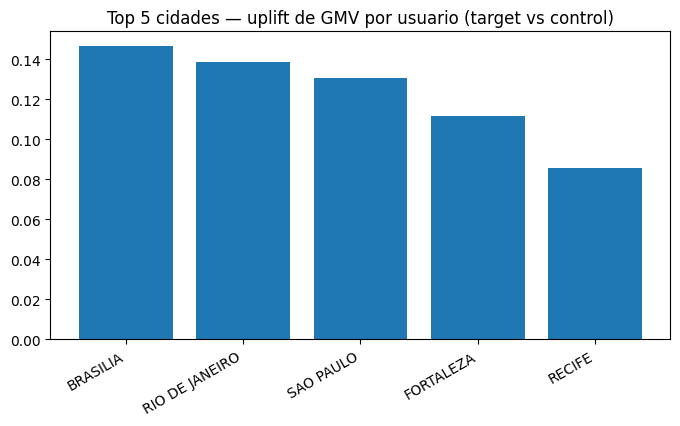

'reports/ab_test_por_cidade_top5.csv'

In [36]:
REPORT_AB_CITY = os.path.join(DIRS["reports"], "ab_test_por_cidade_top5.csv")
city_pivot.to_csv(REPORT_AB_CITY, index=False)

plt.figure(figsize=(8, 4))
plt.bar(city_pivot["delivery_address_city"], city_pivot["uplift_gmv_pct"])
plt.title("Top 5 cidades — uplift de GMV por usuario (target vs control)")
plt.xticks(rotation=30, ha="right")
plt.show()

REPORT_AB_CITY


## Levantamentos — Viabilidade financeira
A campanha é viável se o lucro vindo das vendas extras for maior que o custo total dos cupons distribuídos, usando o uplift observado no experimento.


In [37]:
import numpy as np
import pandas as pd

m_t = df_resultados.loc[df_resultados["metrica"] == "gmv_total", "media_target"].iloc[0]
m_c = df_resultados.loc[df_resultados["metrica"] == "gmv_total", "media_control"].iloc[0]
delta_gmv_user = float(m_t - m_c)

o_t = df_resultados.loc[df_resultados["metrica"] == "num_orders", "media_target"].iloc[0]
o_c = df_resultados.loc[df_resultados["metrica"] == "num_orders", "media_control"].iloc[0]
delta_orders_user = float(o_t - o_c)

users_target = int(target["customer_id"].nunique())

margens = [0.05, 0.10, 0.15, 0.20]

sens = []
for m in margens:
    ganho_bruto_user = delta_gmv_user * m
    sens.append({
        "margem_assumida": m,
        "delta_gmv_por_usuario": delta_gmv_user,
        "delta_pedidos_por_usuario": delta_orders_user,
        "ganho_bruto_por_usuario": ganho_bruto_user,
        "custo_max_cupom_por_usuario_break_even": ganho_bruto_user,
        "custo_max_cupom_por_pedido_incremental_break_even": (ganho_bruto_user / delta_orders_user) if delta_orders_user > 0 else np.nan,
        "ganho_bruto_total_target": ganho_bruto_user * users_target,
    })

sens_df = pd.DataFrame(sens)
sens_df.to_csv(REPORT_VIAB, index=False)

sens_df


,margem_assumida,delta_gmv_por_usuario,delta_pedidos_por_usuario,ganho_bruto_por_usuario,custo_max_cupom_por_usuario_break_even,custo_max_cupom_por_pedido_incremental_break_even,ganho_bruto_total_target
0,0.05,17.555183,0.373562,0.877759,0.877759,2.349700,3.914139e+05
1,0.10,17.555183,0.373562,1.755518,1.755518,4.699399,7.828278e+05
2,0.15,17.555183,0.373562,2.633278,2.633278,7.049099,1.174242e+06
3,0.20,17.555183,0.373562,3.511037,3.511037,9.398799,1.565656e+06


## Levantamentos — Segmentação de usuários

Segmentação baseada em comportamento observado no período:
- Frequência: tercis de `num_orders`
- Monetário: tercis de `gmv_total`


In [38]:
import pandas as pd

df_seg = user_metrics[["customer_id", "is_target", "num_orders", "gmv_total"]].copy()

df_seg["freq_tercil"] = pd.qcut(df_seg["num_orders"].rank(method="first"), 3, labels=["baixa", "media", "alta"])
df_seg["monet_tercil"] = pd.qcut(df_seg["gmv_total"].rank(method="first"), 3, labels=["baixo", "medio", "alto"])

df_seg["segmento"] = "F_" + df_seg["freq_tercil"].astype(str) + "_M_" + df_seg["monet_tercil"].astype(str)

user_segments = df_seg[["customer_id", "segmento", "freq_tercil", "monet_tercil"]].copy()
user_segments.to_parquet(PATH_USER_SEGMENTS, index=False)

user_segments["segmento"].value_counts().head(10)


,count
segmento,
F_alta_M_alto,218736
F_baixa_M_baixo,174550
F_media_M_medio,135662
F_media_M_baixo,92353
F_baixa_M_medio,84993
F_alta_M_medio,48167
F_media_M_alto,40807
F_baixa_M_alto,9279
F_alta_M_baixo,1919


Reavalia o uplift do teste A/B dentro de cada segmento.


In [39]:
df_seg_full = user_metrics.merge(user_segments[["customer_id", "segmento"]], on="customer_id", how="left")

ab_seg = (
    df_seg_full.groupby(["segmento", "is_target"], as_index=False)
      .agg(
          users=("customer_id", "nunique"),
          media_pedidos=("num_orders", "mean"),
          media_gmv=("gmv_total", "mean"),
          pct_2mais=("num_orders", lambda s: float((s >= 2).mean())),
      )
)

pivot = ab_seg.pivot(index="segmento", columns="is_target")
pivot.columns = [f"{a}_{b}" for a, b in pivot.columns]
pivot = pivot.reset_index()

pivot["uplift_pedidos_pct"] = pivot["media_pedidos_target"] / pivot["media_pedidos_control"] - 1
pivot["uplift_gmv_pct"] = pivot["media_gmv_target"] / pivot["media_gmv_control"] - 1
pivot["diff_pct_2mais"] = pivot["pct_2mais_target"] - pivot["pct_2mais_control"]

pivot = pivot.sort_values("uplift_gmv_pct", ascending=False).reset_index(drop=True)

pivot.to_csv(REPORT_AB_SEG, index=False)

pivot.head(15)


,segmento,users_control,users_target,media_pedidos_control,media_pedidos_target,media_gmv_control,media_gmv_target,pct_2mais_control,pct_2mais_target,uplift_pedidos_pct,uplift_gmv_pct,diff_pct_2mais
0,F_baixa_M_alto,4673,4606,1.000000,1.000000,171.787376,177.702099,0.000000,0.000000,0.000000,0.034430,0.000000
1,F_media_M_baixo,43968,48385,1.196848,1.275478,32.400917,32.926319,0.195074,0.272791,0.065698,0.016216,0.077717
2,F_media_M_medio,57802,77860,1.727120,1.808233,77.115938,78.065020,0.699266,0.777575,0.046964,0.012307,0.078309
3,F_alta_M_alto,87931,130805,7.066075,7.078200,354.722780,356.201506,1.000000,1.000000,0.001716,0.004169,0.000000
4,F_baixa_M_baixo,87171,87379,1.000000,1.000000,30.909081,31.021520,0.000000,0.000000,0.000000,0.003638,0.000000
5,F_alta_M_baixo,768,1151,3.127604,3.136403,41.038750,41.096716,1.000000,1.000000,0.002813,0.001412,0.000000
6,F_baixa_M_medio,42346,42647,1.000000,1.000000,68.411276,68.356212,0.000000,0.000000,0.000000,-0.000805,0.000000
7,F_alta_M_medio,19231,28936,3.486714,3.481649,91.846084,91.753131,1.000000,1.000000,-0.001453,-0.001012,0.000000
8,F_media_M_alto,16652,24155,2.000480,2.041937,190.194819,178.811110,0.887761,0.922873,0.020724,-0.059853,0.035112


- efeito observado (frequência/GMV)
- viabilidade (sensibilidade por margem)
- segmentos com maior retorno potencial


In [40]:
top_seg = pivot[["segmento", "uplift_gmv_pct", "uplift_pedidos_pct", "diff_pct_2mais", "users_target", "users_control"]].head(6).copy()

reco = []
for _, r in top_seg.iterrows():
    reco.append({
        "segmento": r["segmento"],
        "acao_sugerida": "Priorizar cupom segmentado com controle de custo (cap por usuario) e foco em recorrencia",
        "racional": "Segmento com maior uplift relativo em GMV e/ou pedidos",
        "uplift_gmv_pct": float(r["uplift_gmv_pct"]),
        "uplift_pedidos_pct": float(r["uplift_pedidos_pct"]),
        "diff_pct_2mais": float(r["diff_pct_2mais"]),
    })

df_reco = pd.DataFrame(reco)
df_reco.to_csv(REPORT_RECO, index=False)

df_reco


,segmento,acao_sugerida,racional,uplift_gmv_pct,uplift_pedidos_pct,diff_pct_2mais
0,F_baixa_M_alto,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...,0.034430,0.000000,0.000000
1,F_media_M_baixo,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...,0.016216,0.065698,0.077717
2,F_media_M_medio,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...,0.012307,0.046964,0.078309
3,F_alta_M_alto,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...,0.004169,0.001716,0.000000
4,F_baixa_M_baixo,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...,0.003638,0.000000,0.000000
5,F_alta_M_baixo,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...,0.001412,0.002813,0.000000


## 7. Geração do PDF final

Gera um PDF consolidando resultados e premissa.

In [41]:
!pip install fpdf2

In [42]:
!pip -q install reportlab

# Camada de apresentação (linguagem de negócio)

Esta seção **não altera os cálculos** do case. Ela apenas:
- padroniza nomes para negócio (Controle/Experimento, Valor total comprado),
- melhora legibilidade de tabelas e gráficos,

> Objetivo: melhorar a legibilidade de pronto das tabelas

In [43]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Diretórios
if "DIRS" in globals():
    REPORT_DIR = Path(DIRS["reports"])
else:
    # fallback
    REPORT_DIR = Path("reports")
REPORT_DIR.mkdir(exist_ok=True, parents=True)

IMG_DIR = REPORT_DIR / "imgs"
IMG_DIR.mkdir(exist_ok=True, parents=True)

# Padrões de linguagem (negócio)
MAP_GRUPO = {"control": "Controle", "target": "Experimento"}
MAP_METRICA = {
    "gmv_total": "Valor total comprado por usuário (R$)",
    "num_orders": "Pedidos por usuário",
    "pct_com_2mais_pedidos": "Clientes com 2+ pedidos (%)",
    "ticket_medio": "Ticket médio (R$)",
}

def format_brl(x):
    return f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def format_pct(x, casas=1):
    return f"{x*100:.{casas}f}%"

def format_pp(x, casas=1):
    return f"{x*100:.{casas}f} p.p."

def rotulo_segmento(seg):
    # Ex: F_baixa_M_alto -> Poucos pedidos • Alto valor comprado
    if not isinstance(seg, str) or "F_" not in seg or "_M_" not in seg:
        return seg
    f = seg.split("_M_")[0].replace("F_", "")
    m = seg.split("_M_")[1]
    f_map = {"baixa": "Poucos pedidos", "media": "Pedidos médios", "alta": "Muitos pedidos"}
    m_map = {"baixo": "Baixo valor comprado", "medio": "Valor comprado médio", "alto": "Alto valor comprado"}
    return f"{f_map.get(f, f)} • {m_map.get(m, m)}"

def _find_file(filename: str):
    # procura no REPORT_DIR e no /mnt/data (ambiente deste chat)
    candidates = [
        REPORT_DIR / filename,
        Path("outputs") / filename,
        Path(filename),
        Path("/mnt/data") / filename,
        Path("/mnt/data/outputs") / filename,
        Path("/mnt/data/reports") / filename,
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Não encontrei {filename} em locais comuns. Procurei em: {candidates}")

def _save_png(name: str):
    p = IMG_DIR / name
    plt.savefig(p, dpi=200, bbox_inches="tight")
    plt.close()
    return p


In [44]:

# 1)outputs técnicos
ab_path = _find_file("ab_test_results.csv")
seg_path = _find_file("ab_test_por_segmento.csv")
city_path = _find_file("ab_test_por_cidade_top5.csv")
via_path = _find_file("viabilidade_sensibilidade.csv")
rec_path = _find_file("recomendacoes_resumo.csv")

ab = pd.read_csv(ab_path)
seg = pd.read_csv(seg_path)
city = pd.read_csv(city_path)
via = pd.read_csv(via_path)
rec = pd.read_csv(rec_path)

ab.head(), seg.head(), city.head(), via.head(), rec.head()


(                 metrica  media_target  media_control   diff_abs  uplift_pct  \
 0              gmv_total    151.886838     134.331655  17.555183    0.130685   
 1             num_orders      3.176947       2.803385   0.373562    0.133254   
 2  pct_com_2mais_pedidos      0.576163       0.476252   0.099911    0.209785   
 3           ticket_medio     47.834905      48.002943  -0.168038   -0.003501   
 
          p_value        teste  
 0  2.343230e-171      welch_t  
 1   0.000000e+00      welch_t  
 2   0.000000e+00  z_proporcao  
 3   4.447794e-01      welch_t  ,
           segmento  users_control  users_target  media_pedidos_control  \
 0   F_baixa_M_alto           4673          4606               1.000000   
 1  F_media_M_baixo          43968         48385               1.196848   
 2  F_media_M_medio          57802         77860               1.727120   
 3    F_alta_M_alto          87931        130805               7.066075   
 4  F_baixa_M_baixo          87171         87379    

In [45]:

# 2) Tabela 1: impacto geral
ab_out = ab.copy()
ab_out["Métrica"] = ab_out["metrica"].map(MAP_METRICA).fillna(ab_out["metrica"])

ab_out = ab_out.rename(columns={
    "media_control": "Controle",
    "media_target": "Experimento",
    "diff_abs": "Diferença",
    "uplift_pct": "Variação (%)"
})[["Métrica","Controle","Experimento","Diferença","Variação (%)"]]

# Formatação por tipo
mask_brl = ab_out["Métrica"].str.contains("(R$)", regex=False)
mask_2mais = ab_out["Métrica"].str.contains("2+ pedidos", regex=False)

ab_out.loc[mask_brl, ["Controle","Experimento","Diferença"]] = ab_out.loc[mask_brl, ["Controle","Experimento","Diferença"]].applymap(format_brl)
ab_out.loc[~mask_brl, ["Controle","Experimento","Diferença"]] = ab_out.loc[~mask_brl, ["Controle","Experimento","Diferença"]].applymap(lambda x: f"{float(x):.2f}")

ab_out["Variação (%)"] = ab_out["Variação (%)"].map(lambda x: format_pct(float(x), 1))

# Para 2+ pedidos
if mask_2mais.any():
    raw = ab.loc[ab["metrica"]=="pct_com_2mais_pedidos"].iloc[0]
    idx = ab_out.index[mask_2mais][0]
    ab_out.loc[idx, "Controle"] = format_pct(float(raw["media_control"]), 1)
    ab_out.loc[idx, "Experimento"] = format_pct(float(raw["media_target"]), 1)
    ab_out.loc[idx, "Diferença"] = format_pp(float(raw["diff_abs"]), 1)

# Sobrescrever o CSv
ab_out.to_csv(ab_path, index=False)
ab_out


/tmp/ipython-input-2896840680.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ab_out.loc[mask_brl, ["Controle","Experimento","Diferença"]] = ab_out.loc[mask_brl, ["Controle","Experimento","Diferença"]].applymap(format_brl)
/tmp/ipython-input-2896840680.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['R$ 134,33' 'R$ 48,00']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ab_out.loc[mask_brl, ["Controle","Experimento","Diferença"]] = ab_out.loc[mask_brl, ["Controle","Experimento","Diferença"]].applymap(format_brl)
/tmp/ipython-input-2896840680.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['R$ 151,89' 'R$ 47,83']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ab_out.loc[mask_brl, ["

,Métrica,Controle,Experimento,Diferença,Variação (%)
0,Valor total comprado por usuário (R$),"R$ 134,33","R$ 151,89","R$ 17,56",13.1%
1,Pedidos por usuário,2.80,3.18,0.37,13.3%
2,Clientes com 2+ pedidos (%),47.6%,57.6%,10.0 p.p.,21.0%
3,Ticket médio (R$),"R$ 48,00","R$ 47,83","R$ -0,17",-0.4%


In [46]:

# 3) Segmentos
seg_out = seg.copy()
seg_out["Segmento"] = seg_out["segmento"].map(rotulo_segmento)

seg_out = seg_out.rename(columns={
    "users_control": "Usuários (Controle)",
    "users_target": "Usuários (Experimento)",
    "uplift_gmv_pct": "Variação no valor comprado (%)",
    "uplift_pedidos_pct": "Variação em pedidos (%)",
    "diff_pct_2mais": "Ganho em 2+ pedidos (p.p.)",
    "media_gmv_control": "Controle — valor comprado médio (R$)",
    "media_gmv_target": "Experimento — valor comprado médio (R$)",
    "media_pedidos_control": "Controle — pedidos médios",
    "media_pedidos_target": "Experimento — pedidos médios",
})

keep_cols = [
    "Segmento",
    "Usuários (Controle)",
    "Usuários (Experimento)",
    "Variação no valor comprado (%)",
    "Variação em pedidos (%)",
    "Ganho em 2+ pedidos (p.p.)",
]
seg_out = seg_out[keep_cols].copy()

# Formatação
seg_out["Variação no valor comprado (%)"] = (seg_out["Variação no valor comprado (%)"]*100).map(lambda x: f"{x:.1f}%")
seg_out["Variação em pedidos (%)"] = (seg_out["Variação em pedidos (%)"]*100).map(lambda x: f"{x:.1f}%")
seg_out["Ganho em 2+ pedidos (p.p.)"] = (seg_out["Ganho em 2+ pedidos (p.p.)"]*100).map(lambda x: f"{x:.1f} p.p.")

# Ordenação
seg_out = seg_out.sort_values("Variação no valor comprado (%)", ascending=False)

seg_out.to_csv(seg_path, index=False)
seg_out.head(10)


,Segmento,Usuários (Controle),Usuários (Experimento),Variação no valor comprado (%),Variação em pedidos (%),Ganho em 2+ pedidos (p.p.)
0,Poucos pedidos • Alto valor comprado,4673,4606,3.4%,0.0%,0.0 p.p.
1,Pedidos médios • Baixo valor comprado,43968,48385,1.6%,6.6%,7.8 p.p.
2,Pedidos médios • Valor comprado médio,57802,77860,1.2%,4.7%,7.8 p.p.
3,Muitos pedidos • Alto valor comprado,87931,130805,0.4%,0.2%,0.0 p.p.
4,Poucos pedidos • Baixo valor comprado,87171,87379,0.4%,0.0%,0.0 p.p.
5,Muitos pedidos • Baixo valor comprado,768,1151,0.1%,0.3%,0.0 p.p.
8,Pedidos médios • Alto valor comprado,16652,24155,-6.0%,2.1%,3.5 p.p.
6,Poucos pedidos • Valor comprado médio,42346,42647,-0.1%,0.0%,0.0 p.p.
7,Muitos pedidos • Valor comprado médio,19231,28936,-0.1%,-0.1%,0.0 p.p.


In [47]:

# 4) Cidades Top 5
city_out = city.copy().rename(columns={
    "delivery_address_city": "Cidade",
    "users_control": "Usuários (Controle)",
    "users_target": "Usuários (Experimento)",
    "uplift_gmv_pct": "Variação no valor comprado (%)",
    "uplift_pedidos_pct": "Variação em pedidos (%)",
    "diff_pct_2mais": "Ganho em 2+ pedidos (p.p.)",
})

city_out = city_out[[
    "Cidade","Usuários (Controle)","Usuários (Experimento)",
    "Variação no valor comprado (%)","Variação em pedidos (%)","Ganho em 2+ pedidos (p.p.)"
]].copy()

city_out["Variação no valor comprado (%)"] = (city_out["Variação no valor comprado (%)"]*100).map(lambda x: f"{x:.1f}%")
city_out["Variação em pedidos (%)"] = (city_out["Variação em pedidos (%)"]*100).map(lambda x: f"{x:.1f}%")
city_out["Ganho em 2+ pedidos (p.p.)"] = (city_out["Ganho em 2+ pedidos (p.p.)"]*100).map(lambda x: f"{x:.1f} p.p.")

city_out = city_out.sort_values("Variação no valor comprado (%)", ascending=False)

city_out.to_csv(city_path, index=False)
city_out


,Cidade,Usuários (Controle),Usuários (Experimento),Variação no valor comprado (%),Variação em pedidos (%),Ganho em 2+ pedidos (p.p.)
4,RECIFE,12504,15816,8.6%,9.0%,8.7 p.p.
0,BRASILIA,13120,16292,14.7%,14.2%,9.1 p.p.
1,RIO DE JANEIRO,58766,73805,13.9%,13.4%,9.9 p.p.
2,SAO PAULO,98849,122492,13.1%,12.8%,9.6 p.p.
3,FORTALEZA,13253,16942,11.2%,11.0%,8.9 p.p.


In [48]:

# 5)Melhora tabela
via_out = via.copy()

via_out = via_out.rename(columns={
    "margem_assumida": "Margem (%)",
    "custo_max_cupom_por_usuario_break_even": "Teto do cupom por usuário (R$)",
    "custo_max_cupom_por_pedido_incremental_break_even": "Teto do cupom por pedido incremental (R$)",
})[["Margem (%)","Teto do cupom por usuário (R$)","Teto do cupom por pedido incremental (R$)"]]

via_out["Margem (%)"] = (via_out["Margem (%)"]*100).map(lambda x: f"{x:.0f}%")
via_out["Teto do cupom por usuário (R$)"] = via_out["Teto do cupom por usuário (R$)"].map(format_brl)
via_out["Teto do cupom por pedido incremental (R$)"] = via_out["Teto do cupom por pedido incremental (R$)"].map(format_brl)

via_out.to_csv(via_path, index=False)
via_out


,Margem (%),Teto do cupom por usuário (R$),Teto do cupom por pedido incremental (R$)
0,5%,"R$ 0,88","R$ 2,35"
1,10%,"R$ 1,76","R$ 4,70"
2,15%,"R$ 2,63","R$ 7,05"
3,20%,"R$ 3,51","R$ 9,40"


In [49]:

# 6) Limpeza de nomes
rec_out = rec.copy()
rec_out["Segmento"] = rec_out["segmento"].map(rotulo_segmento)

rec_out = rec_out.rename(columns={
    "acao_sugerida": "O que fazer",
    "racional": "Por quê"
})[["Segmento","O que fazer","Por quê"]]

def _short(s, n=160):
    s = str(s)
    return s if len(s) <= n else s[:n-1] + "…"

rec_out["O que fazer"] = rec_out["O que fazer"].map(lambda s: _short(s, 160))
rec_out["Por quê"] = rec_out["Por quê"].map(lambda s: _short(s, 180))

rec_out.to_csv(rec_path, index=False)
rec_out.head(10)


,Segmento,O que fazer,Por quê
0,Poucos pedidos • Alto valor comprado,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...
1,Pedidos médios • Baixo valor comprado,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...
2,Pedidos médios • Valor comprado médio,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...
3,Muitos pedidos • Alto valor comprado,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...
4,Poucos pedidos • Baixo valor comprado,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...
5,Muitos pedidos • Baixo valor comprado,Priorizar cupom segmentado com controle de cus...,Segmento com maior uplift relativo em GMV e/ou...


In [50]:

# 7) Gráficos executivos
ab_now = pd.read_csv(ab_path)

def _to_float(v):
    if isinstance(v, str):
        v = v.replace("R$", "").replace(".", "").replace(",", ".").replace("%","").strip()
    return float(v)

# Pedidos por usuário
row_ped = ab_now.loc[ab_now["Métrica"]=="Pedidos por usuário"].iloc[0]
controle_ped = _to_float(row_ped["Controle"])
exper_ped = _to_float(row_ped["Experimento"])

plt.figure(figsize=(6.2,4.0))
plt.bar(["Controle","Experimento"], [controle_ped, exper_ped])
plt.title("Pedidos por usuário — Controle vs Experimento")
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
for i, v in enumerate([controle_ped, exper_ped]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
png_ped = _save_png("01_pedidos_controle_vs_experimento.png")

# Valor total comprado por usuário
row_val = ab_now.loc[ab_now["Métrica"]=="Valor total comprado por usuário (R$)"].iloc[0]
controle_val = _to_float(row_val["Controle"])
exper_val = _to_float(row_val["Experimento"])

plt.figure(figsize=(6.2,4.0))
plt.bar(["Controle","Experimento"], [controle_val, exper_val])
plt.title("Valor total comprado por usuário (R$) — Controle vs Experimento")
plt.ylabel("R$")
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
for i, v in enumerate([controle_val, exper_val]):
    plt.text(i, v, format_brl(v), ha="center", va="bottom")
png_val = _save_png("02_valor_comprado_controle_vs_experimento.png")

# 7.2 Top 5 segmentos (horizontal)
seg_now = pd.read_csv(seg_path)
seg_now["Variação no valor comprado (%)_num"] = seg_now["Variação no valor comprado (%)"].str.replace("%","").astype(float)

top_seg = seg_now.sort_values("Variação no valor comprado (%)_num", ascending=False).head(5).copy()
plt.figure(figsize=(8,4.4))
plt.barh(top_seg["Segmento"], top_seg["Variação no valor comprado (%)_num"])
plt.title("Top 5 segmentos — variação no valor comprado (%)")
plt.xlabel("Variação (%)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.6)
for i, v in enumerate(top_seg["Variação no valor comprado (%)_num"].values):
    plt.text(v, i, f" {v:.1f}%", va="center")
png_seg = _save_png("03_top_segmentos_valor_comprado.png")

# 7.3 Top 5 cidades (horizontal)
city_now = pd.read_csv(city_path)
city_now["Variação no valor comprado (%)_num"] = city_now["Variação no valor comprado (%)"].str.replace("%","").astype(float)

top_city = city_now.sort_values("Variação no valor comprado (%)_num", ascending=False).head(5).copy()
plt.figure(figsize=(8,4.0))
plt.barh(top_city["Cidade"], top_city["Variação no valor comprado (%)_num"])
plt.title("Top 5 cidades — variação no valor comprado (%)")
plt.xlabel("Variação (%)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.6)
for i, v in enumerate(top_city["Variação no valor comprado (%)_num"].values):
    plt.text(v, i, f" {v:.1f}%", va="center")
png_city = _save_png("04_top_cidades.png")

# 7.4 Viabilidade (break-even)
via_now = pd.read_csv(via_path)
via_plot = via.copy()  # via original pode estar em memória técnica; se não, releia do raw antes de sobrescrever em outro notebook
# Se você rodou esta célula após sobrescrever via_path, recarregue o raw original antes de sobrescrever. Aqui usamos 'via' que já estava carregado.

plt.figure(figsize=(7.6,4.2))
plt.plot(via["margem_assumida"]*100, via["custo_max_cupom_por_usuario_break_even"])
plt.title("Viabilidade — teto do cupom por usuário para empatar")
plt.xlabel("Margem (%)")
plt.ylabel("Teto por usuário (R$)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
png_be = _save_png("05_break_even.png")

png_ped, png_val, png_seg, png_city, png_be


(PosixPath('reports/imgs/01_pedidos_controle_vs_experimento.png'),
 PosixPath('reports/imgs/02_valor_comprado_controle_vs_experimento.png'),
 PosixPath('reports/imgs/03_top_segmentos_valor_comprado.png'),
 PosixPath('reports/imgs/04_top_cidades.png'),
 PosixPath('reports/imgs/05_break_even.png'))

In [51]:
import os, re
import pandas as pd

from reportlab.lib.pagesizes import A4, landscape
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import cm


report_dir = REPORT_DIR if "REPORT_DIR" in globals() else DIRS["reports"]
os.makedirs(report_dir, exist_ok=True)
pdf_path = os.path.join(report_dir, "Case_Tecnico_iFood_Resultados.pdf")

ab = pd.read_csv(REPORT_AB_TEST)
seg = pd.read_csv(REPORT_AB_SEG)
viab = pd.read_csv(REPORT_VIAB)

city = None
if "REPORT_AB_CITY" in globals() and isinstance(REPORT_AB_CITY, str) and os.path.exists(REPORT_AB_CITY):
    city = pd.read_csv(REPORT_AB_CITY)


def _to_float_brl(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip().replace("R$", "").strip()
    s = s.replace(".", "").replace(",", ".")
    s = re.sub(r"[^0-9\.\-+]", "", s)
    return None if s in ["", ".", "-", "+"] else float(s)

def _to_float_pct(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    has_pct = "%" in s
    s = s.replace("%", "").strip().replace(",", ".")
    s = re.sub(r"[^0-9\.\-+]", "", s)
    if s in ["", ".", "-", "+"]:
        return None
    v = float(s)
    return v / 100 if has_pct else v

def brl(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    if isinstance(x, str) and x.strip().startswith("R$"):
        return x.strip()
    v = _to_float_brl(x)
    if v is None:
        return str(x).strip()
    return f"R$ {v:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def pct(x, casas=1, sinal=True):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    if isinstance(x, str) and "%" in x:
        return x.strip()
    v = _to_float_pct(x)
    if v is None:
        return str(x).strip()
    val = v * 100
    s = f"{val:+.{casas}f}%" if sinal else f"{val:.{casas}f}%"
    return s.replace(".", ",")

def pp(x, casas=1, sinal=True):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    s0 = str(x).strip()
    if isinstance(x, str) and "p.p" in s0:
        return s0
    v = _to_float_pct(x)
    if v is None:
        return s0
    val = v * 100 if abs(v) <= 1.5 else v
    s = f"{val:+.{casas}f} p.p." if sinal else f"{val:.{casas}f} p.p."
    return s.replace(".", ",")

def num(x, casas=2):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    if isinstance(x, str):
        return x.strip()
    return f"{float(x):.{casas}f}".replace(".", ",")

def inteiro(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    if isinstance(x, str):
        v = _to_float_brl(x)
        return x.strip() if v is None else f"{int(round(v)):,}".replace(",", ".")
    return f"{int(x):,}".replace(",", ".")

def pick(df, *cands):
    for c in cands:
        if c in df.columns:
            return c
    return None


styles = getSampleStyleSheet()
h = ParagraphStyle("h", parent=styles["Heading1"], fontSize=14, leading=18, spaceAfter=8)
b = ParagraphStyle("b", parent=styles["BodyText"], fontSize=9, leading=11)

def as_para(df, col):
    df = df.copy()
    if col in df.columns:
        df[col] = df[col].astype(str).map(lambda s: Paragraph(s.replace("•", "&bull;"), b))
    return df

def make_table(df, wide_first=True):
    df = df.fillna("")
    data = [list(df.columns)] + df.values.tolist()
    total_w = 27 * cm
    if wide_first and len(df.columns) > 1:
        w0 = total_w * 0.48
        rest = (total_w - w0) / (len(df.columns) - 1)
        col_w = [w0] + [rest] * (len(df.columns) - 1)
    else:
        col_w = [total_w / max(1, len(df.columns))] * max(1, len(df.columns))

    t = Table(data, colWidths=col_w, repeatRows=1)
    t.setStyle(TableStyle([
        ("BACKGROUND",(0,0),(-1,0), colors.HexColor("#1F4E79")),
        ("TEXTCOLOR",(0,0),(-1,0), colors.white),
        ("FONTNAME",(0,0),(-1,0), "Helvetica-Bold"),
        ("FONTSIZE",(0,0),(-1,0), 9),
        ("FONTSIZE",(0,1),(-1,-1), 8.5),
        ("GRID",(0,0),(-1,-1), 0.3, colors.lightgrey),
        ("VALIGN",(0,0),(-1,-1), "TOP"),
        ("ROWBACKGROUNDS",(0,1),(-1,-1), [colors.white, colors.HexColor("#fbfbfb")]),
        ("LEFTPADDING",(0,0),(-1,-1), 4),
        ("RIGHTPADDING",(0,0),(-1,-1), 4),
        ("TOPPADDING",(0,0),(-1,-1), 3),
        ("BOTTOMPADDING",(0,0),(-1,-1), 3),
    ]))
    return t

def add_page(story, titulo, df, wrap_col=None, wide_first=True):
    story.append(Paragraph(titulo, h))
    story.append(make_table(as_para(df, wrap_col) if wrap_col else df, wide_first=wide_first))
    story.append(PageBreak())


# ---------------- A/B ----------------
if "metrica" not in ab.columns and "Métrica" in ab.columns:
    ab = ab.rename(columns={"Métrica": "metrica"})
if "media_control" not in ab.columns and "Controle" in ab.columns:
    ab = ab.rename(columns={"Controle": "media_control"})
if "media_target" not in ab.columns and "Experimento" in ab.columns:
    ab = ab.rename(columns={"Experimento": "media_target"})
if "diff_abs" not in ab.columns and "Diferença" in ab.columns:
    ab = ab.rename(columns={"Diferença": "diff_abs"})
if "uplift_pct" not in ab.columns and "Variação (%)" in ab.columns:
    ab = ab.rename(columns={"Variação (%)": "uplift_pct"})

MAP_METRICA = {
    "gmv_total": "Valor total comprado por usuário (R$)",
    "num_orders": "Pedidos por usuário",
    "pct_com_2mais_pedidos": "Clientes com 2+ pedidos (%)",
    "ticket_medio": "Ticket médio (R$)",
}

ab2 = ab.copy()
ab2["Métrica"] = ab2["metrica"].map(MAP_METRICA).fillna(ab2["metrica"]) if "metrica" in ab2.columns else ab2.get("Métrica", "")

ab2 = ab2.rename(columns={
    "media_control": "Controle",
    "media_target": "Experimento",
    "diff_abs": "Diferença",
    "uplift_pct": "Variação (%)",
    "p_value": "p-valor",
    "p_value_bonf": "p-valor (ajustado)",
    "ci_low": "IC 95% (min)",
    "ci_high": "IC 95% (máx)",
})

base_cols = [c for c in ["Métrica","Controle","Experimento","Diferença","Variação (%)"] if c in ab2.columns]
sig_cols = [c for c in ["p-valor","p-valor (ajustado)","IC 95% (min)","IC 95% (máx)"] if c in ab2.columns]

ab_base = ab2[base_cols].copy()
rows = []
for _, r in ab_base.iterrows():
    met = r.get("Métrica", "")
    c = r.get("Controle", "")
    e = r.get("Experimento", "")
    d = r.get("Diferença", "")
    v = r.get("Variação (%)", "")
    if "(R$)" in str(met):
        rows.append([met, brl(c), brl(e), brl(d), pct(v, 1)])
    elif "(%)" in str(met):
        rows.append([met, pct(c, 1, sinal=False), pct(e, 1, sinal=False), pp(d, 1), pct(v, 1)])
    else:
        rows.append([met, num(c, 2), num(e, 2), num(d, 2), pct(v, 1)])
ab_tbl = pd.DataFrame(rows, columns=["Métrica","Controle","Experimento","Diferença","Variação (%)"])

ab_sig = None
if sig_cols:
    ab_sig = ab2[["Métrica"] + sig_cols].copy()
    for c in [x for x in sig_cols if "p-valor" in x]:
        ab_sig[c] = ab_sig[c].map(lambda x: num(x, 4))
    for c in [x for x in sig_cols if "IC 95%" in x]:
        ab_sig[c] = ab_sig[c].map(lambda x: num(x, 4))


# ---------------- Segmentos ----------------
seg_col = pick(seg, "Segmento", "segmento")
if seg_col is None:
    raise KeyError(f"CSV de segmentos sem coluna Segmento. Colunas: {seg.columns.tolist()}")

seg2 = seg.copy()
if seg_col != "Segmento":
    seg2 = seg2.rename(columns={seg_col: "Segmento"})

seg_tbl_cols = [
    ("Segmento", "Segmento"),
    ("Usuários (Controle)", pick(seg2, "Usuários (Controle)", "users_control")),
    ("Usuários (Experimento)", pick(seg2, "Usuários (Experimento)", "users_target", "users_experiment")),
    ("Variação no valor comprado (%)", pick(seg2, "Variação no valor comprado (%)", "uplift_gmv_pct")),
    ("Variação em pedidos (%)", pick(seg2, "Variação em pedidos (%)", "uplift_pedidos_pct")),
    ("Ganho em 2+ pedidos (p.p.)", pick(seg2, "Ganho em 2+ pedidos (p.p.)", "diff_pct_2mais")),
]
seg_tbl_cols = [(out, src) for out, src in seg_tbl_cols if src is not None]
seg_tbl = seg2[[src for _, src in seg_tbl_cols]].copy()
seg_tbl.columns = [out for out, _ in seg_tbl_cols]

if "Usuários (Controle)" in seg_tbl.columns:
    seg_tbl["Usuários (Controle)"] = seg_tbl["Usuários (Controle)"].map(inteiro)
if "Usuários (Experimento)" in seg_tbl.columns:
    seg_tbl["Usuários (Experimento)"] = seg_tbl["Usuários (Experimento)"].map(inteiro)
if "Variação no valor comprado (%)" in seg_tbl.columns:
    seg_tbl["Variação no valor comprado (%)"] = seg_tbl["Variação no valor comprado (%)"].map(lambda x: pct(x, 1))
if "Variação em pedidos (%)" in seg_tbl.columns:
    seg_tbl["Variação em pedidos (%)"] = seg_tbl["Variação em pedidos (%)"].map(lambda x: pct(x, 1))
if "Ganho em 2+ pedidos (p.p.)" in seg_tbl.columns:
    seg_tbl["Ganho em 2+ pedidos (p.p.)"] = seg_tbl["Ganho em 2+ pedidos (p.p.)"].map(lambda x: pp(x, 1))

seg_medias = None
seg_media_cols = [
    ("Segmento","Segmento"),
    ("Pedidos por usuário (Controle)", pick(seg2, "Pedidos por usuário (Controle)", "media_pedidos_control")),
    ("Pedidos por usuário (Experimento)", pick(seg2, "Pedidos por usuário (Experimento)", "media_pedidos_target")),
    ("Valor comprado por usuário (Controle)", pick(seg2, "Valor comprado por usuário (Controle)", "media_gmv_control")),
    ("Valor comprado por usuário (Experimento)", pick(seg2, "Valor comprado por usuário (Experimento)", "media_gmv_target")),
]
if all(src is not None for _, src in seg_media_cols[1:]):
    seg_medias = seg2[[src for _, src in seg_media_cols]].copy()
    seg_medias.columns = [out for out, _ in seg_media_cols]
    seg_medias["Pedidos por usuário (Controle)"] = seg_medias["Pedidos por usuário (Controle)"].map(lambda x: num(x, 2))
    seg_medias["Pedidos por usuário (Experimento)"] = seg_medias["Pedidos por usuário (Experimento)"].map(lambda x: num(x, 2))
    seg_medias["Valor comprado por usuário (Controle)"] = seg_medias["Valor comprado por usuário (Controle)"].map(brl)
    seg_medias["Valor comprado por usuário (Experimento)"] = seg_medias["Valor comprado por usuário (Experimento)"].map(brl)


# ---------------- Cidades ----------------
city_tbl = None
city_medias = None
if city is not None and len(city) > 0:
    ccol = pick(city, "Cidade", "delivery_address_city")
    if ccol is not None:
        c2 = city.copy()
        if ccol != "Cidade":
            c2 = c2.rename(columns={ccol: "Cidade"})

        city_cols = [
            ("Cidade", "Cidade"),
            ("Usuários (Controle)", pick(c2, "Usuários (Controle)", "users_control")),
            ("Usuários (Experimento)", pick(c2, "Usuários (Experimento)", "users_target")),
            ("Variação no valor comprado (%)", pick(c2, "Variação no valor comprado (%)", "uplift_gmv_pct")),
            ("Variação em pedidos (%)", pick(c2, "Variação em pedidos (%)", "uplift_pedidos_pct")),
            ("Ganho em 2+ pedidos (p.p.)", pick(c2, "Ganho em 2+ pedidos (p.p.)", "diff_pct_2mais")),
        ]
        city_cols = [(out, src) for out, src in city_cols if src is not None]
        city_tbl = c2[[src for _, src in city_cols]].copy()
        city_tbl.columns = [out for out, _ in city_cols]

        if "Usuários (Controle)" in city_tbl.columns:
            city_tbl["Usuários (Controle)"] = city_tbl["Usuários (Controle)"].map(inteiro)
        if "Usuários (Experimento)" in city_tbl.columns:
            city_tbl["Usuários (Experimento)"] = city_tbl["Usuários (Experimento)"].map(inteiro)
        if "Variação no valor comprado (%)" in city_tbl.columns:
            city_tbl["Variação no valor comprado (%)"] = city_tbl["Variação no valor comprado (%)"].map(lambda x: pct(x, 1))
        if "Variação em pedidos (%)" in city_tbl.columns:
            city_tbl["Variação em pedidos (%)"] = city_tbl["Variação em pedidos (%)"].map(lambda x: pct(x, 1))
        if "Ganho em 2+ pedidos (p.p.)" in city_tbl.columns:
            city_tbl["Ganho em 2+ pedidos (p.p.)"] = city_tbl["Ganho em 2+ pedidos (p.p.)"].map(lambda x: pp(x, 1))

        c_media_cols = [
            ("Cidade","Cidade"),
            ("Pedidos por usuário (Controle)", pick(c2, "Pedidos por usuário (Controle)", "media_pedidos_control")),
            ("Pedidos por usuário (Experimento)", pick(c2, "Pedidos por usuário (Experimento)", "media_pedidos_target")),
            ("Valor comprado por usuário (Controle)", pick(c2, "Valor comprado por usuário (Controle)", "media_gmv_control")),
            ("Valor comprado por usuário (Experimento)", pick(c2, "Valor comprado por usuário (Experimento)", "media_gmv_target")),
        ]
        if all(src is not None for _, src in c_media_cols[1:]):
            city_medias = c2[[src for _, src in c_media_cols]].copy()
            city_medias.columns = [out for out, _ in c_media_cols]
            city_medias["Pedidos por usuário (Controle)"] = city_medias["Pedidos por usuário (Controle)"].map(lambda x: num(x, 2))
            city_medias["Pedidos por usuário (Experimento)"] = city_medias["Pedidos por usuário (Experimento)"].map(lambda x: num(x, 2))
            city_medias["Valor comprado por usuário (Controle)"] = city_medias["Valor comprado por usuário (Controle)"].map(brl)
            city_medias["Valor comprado por usuário (Experimento)"] = city_medias["Valor comprado por usuário (Experimento)"].map(brl)


# ---------------- Viabilidade ----------------
if "margem_assumida" in viab.columns:
    v2 = viab.copy().rename(columns={
        "margem_assumida": "Margem (%)",
        "ganho_bruto_por_usuario": "Ganho bruto por usuário (R$)",
        "custo_max_cupom_por_usuario_break_even": "Teto do cupom por usuário (R$)",
        "custo_max_cupom_por_pedido_incremental_break_even": "Teto do cupom por pedido incremental (R$)",
        "ganho_bruto_total_target": "Ganho bruto total no Experimento (R$)",
    })
else:
    v2 = viab.copy()

pref = [
    "Margem (%)",
    "Ganho bruto por usuário (R$)",
    "Teto do cupom por usuário (R$)",
    "Teto do cupom por pedido incremental (R$)",
    "Ganho bruto total no Experimento (R$)",
]
cols = [c for c in pref if c in v2.columns]
viab_tbl = v2[cols].copy() if cols else v2.copy()

if "Margem (%)" in viab_tbl.columns:
    viab_tbl["Margem (%)"] = viab_tbl["Margem (%)"].map(lambda x: pct(x, 0, sinal=False))
for c in ["Ganho bruto por usuário (R$)", "Teto do cupom por usuário (R$)", "Teto do cupom por pedido incremental (R$)", "Ganho bruto total no Experimento (R$)"]:
    if c in viab_tbl.columns:
        viab_tbl[c] = viab_tbl[c].map(lambda x: brl(x).replace(",00", ""))

viab_full = None
if len(v2.columns) > len(viab_tbl.columns):
    keep = [c for c in v2.columns if c not in cols]
    cand = cols + keep
    viab_full = v2[cand].copy()


# ---------------- PDF ----------------
doc = SimpleDocTemplate(
    pdf_path,
    pagesize=landscape(A4),
    leftMargin=1.2*cm, rightMargin=1.2*cm,
    topMargin=1.2*cm, bottomMargin=1.2*cm
)

story = []
story.append(Paragraph("Levantamentos — Controle vs Experimento", h))
story.append(Paragraph("Tabelas de apoio para montagem do relatório final fora do notebook.", b))
story.append(Spacer(1, 10))

add_page(story, "1) A/B — Resumo (impacto)", ab_tbl, wrap_col="Métrica", wide_first=True)
if ab_sig is not None:
    add_page(story, "2) A/B — Significância (p-valor e intervalo de confiança)", ab_sig, wrap_col="Métrica", wide_first=True)

add_page(story, "3) Segmentos — Impacto", seg_tbl, wrap_col="Segmento", wide_first=True)
if seg_medias is not None:
    add_page(story, "4) Segmentos — Médias por grupo", seg_medias, wrap_col="Segmento", wide_first=True)

if city_tbl is not None:
    add_page(story, "5) Cidades — Impacto", city_tbl, wrap_col="Cidade", wide_first=True)
if city_medias is not None:
    add_page(story, "6) Cidades — Médias por grupo", city_medias, wrap_col="Cidade", wide_first=True)

story.append(Paragraph("7) Viabilidade — Break-even", h))
story.append(make_table(viab_tbl, wide_first=False))

if viab_full is not None:
    story.append(PageBreak())
    story.append(Paragraph("8) Viabilidade — Sensibilidade (tabela completa)", h))
    story.append(make_table(viab_full, wide_first=False))

doc.build(story)
print("PDF gerado em:", pdf_path)


PDF gerado em: reports/Case_Tecnico_iFood_Resultados.pdf
